# CS 229 Project Proposal Notebook

In [1]:
import sys
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

sys.path.append('..')
from helpers import get_mnist
from networks import make_standard_net, make_skd_net  # import k-dropout model

### Load Data and Define Helper Functions

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# load data
batch_size = 512
num_workers = 4
train_loader, test_loader = get_mnist(train_batch_size=batch_size, num_workers=4)

# move data to the gpu
train_set = []
for batch in train_loader:
    X, y = batch
    X = X.to(device)
    y = y.to(device)
    train_set.append([X, y])

test_set = []
for batch in test_loader:
    X, y = batch
    X = X.to(device)
    y = y.to(device)
    test_set.append([X, y])

In [4]:
def train_model(net, lr=0.0005, epochs=100, eval_every=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    train_loss = []
    test_loss = []
    test_acc = []
    for epoch in tqdm(range(epochs)):
        # train
        net.train()
        epoch_loss = 0
        for X, y in train_set:
            net.zero_grad()
            logits = net(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.detach().cpu().item()
        train_loss.append(epoch_loss)

        # evaluate
        if epoch % eval_every == 0:
            net.eval()
            with torch.no_grad():
                epoch_loss = 0
                n_correct = 0
                n_total = 0
                for X, y in test_set:
                    logits = net(X)
                    loss = criterion(logits, y)
                    epoch_loss += loss.item()
                    n_correct += (logits.argmax(dim=1) == y).sum().item()
                    n_total += len(y)
                test_loss.append(epoch_loss)
                test_acc.append(n_correct / n_total)
    return {
        'train_loss': np.array(train_loss),
        'test_loss': np.array(test_loss),
        'test_acc': np.array(test_acc),
    }

### Train Models

We train a model with a set architecture across a variety of values for the $k$ parameter.
For this initial run we do only one restart for each value of $k$ and keep the other hyperparameters constant
(dropout probablity, batch size, number of subnetworks per minibatch, learning rate, total training steps).

We also train a standard model without dropout.

In [5]:
# train models
lr = 0.0005
epochs = 200
restarts = 1
ks = [1, 5, 15, 50, 200, 1000, len(train_set) * epochs]  # sweep across a variety of k values

results = {str(k): [] for k in ks + ['standard']}

# no dropout model
for r in range(restarts):
    print(f'standard model, restart {r+1}/{restarts}')
    net = make_standard_net(hidden_units=1200, hidden_layers=2).to(device)
    results['standard'].append(train_model(net, lr=lr, epochs=epochs))

# sequential k dropout model
for k in ks:
    for r in range(restarts):
        print(f'skd model, k={k}, restart {r+1}/{restarts}')
        net = make_skd_net(hidden_units=1200, hidden_layers=2, k=k).to(device)
        results[str(k)].append(train_model(net, lr=lr, epochs=epochs))


standard model, restart 1/1


100%|██████████| 200/200 [01:44<00:00,  1.92it/s]


skd model, k=1, restart 1/1


100%|██████████| 200/200 [01:53<00:00,  1.76it/s]


skd model, k=5, restart 1/1


100%|██████████| 200/200 [01:47<00:00,  1.87it/s]


skd model, k=15, restart 1/1


100%|██████████| 200/200 [01:44<00:00,  1.91it/s]


skd model, k=50, restart 1/1


100%|██████████| 200/200 [01:45<00:00,  1.90it/s]


skd model, k=200, restart 1/1


100%|██████████| 200/200 [01:44<00:00,  1.91it/s]


skd model, k=1000, restart 1/1


100%|██████████| 200/200 [01:46<00:00,  1.88it/s]


skd model, k=23400, restart 1/1


100%|██████████| 200/200 [01:50<00:00,  1.80it/s]


In [6]:
train_loss_mean = {k: np.stack([r['train_loss'] for r in v], axis=0).mean(axis=0) for k, v in results.items()}
test_loss_mean = {k: np.stack([r['test_loss'] for r in v], axis=0).mean(axis=0) for k, v in results.items()}
test_acc_mean = {k: np.stack([r['test_acc'] for r in v], axis=0).mean(axis=0) for k, v in results.items()}

### Visualize Results

Text(0, 0.5, 'Train Loss')

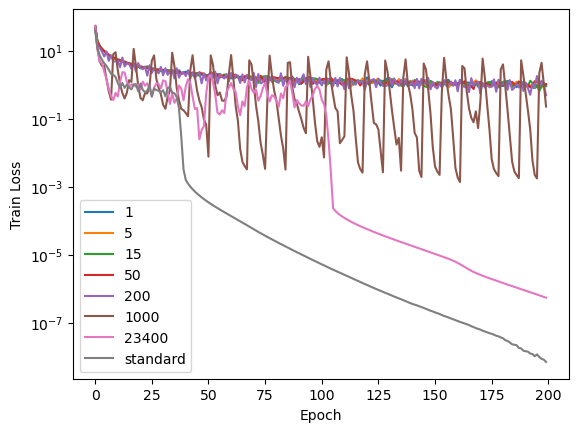

In [7]:
# plot train loss
for m in train_loss_mean.keys():
    plt.plot(train_loss_mean[m], label=m)
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Train Loss')

We can observe that both the standard model with no dropout
and k-dropout with $k=23400$ (where the same mask is used for each minibatch)
overfit and trend to zero loss.

For small k we observe a regularizing effect where the loss appears to be asymptotically bounded.
For intermediate values of k ($k=1000$ and possibly also $k=200$),
we see periodic behavior where the the training loss is high after a new mask is sampled
then drops over the next few epochs.

Text(0, 0.5, 'Test Accuracy')

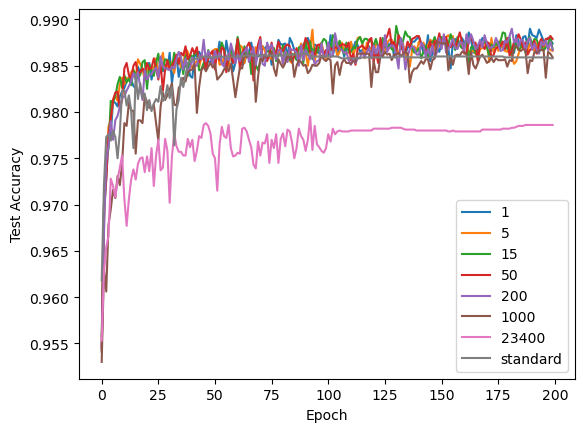

In [8]:
# plot test accuracy
for m in test_acc_mean:
    plt.plot(test_acc_mean[m], label=m)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')

In [9]:
# test accuracy over final few epochs
avg = 10
for k, acc in test_acc_mean.items():
    print(f'{k}: {acc[-avg:].mean():.4f} ± {acc[-avg:].std():.4f}')

1: 0.9880 ± 0.0004
5: 0.9870 ± 0.0004
15: 0.9873 ± 0.0005
50: 0.9875 ± 0.0006
200: 0.9871 ± 0.0005
1000: 0.9861 ± 0.0009
23400: 0.9786 ± 0.0000
standard: 0.9859 ± 0.0000


Text(0.5, 1.0, 'Mean Test Accuracy Over Final 10 Epochs')

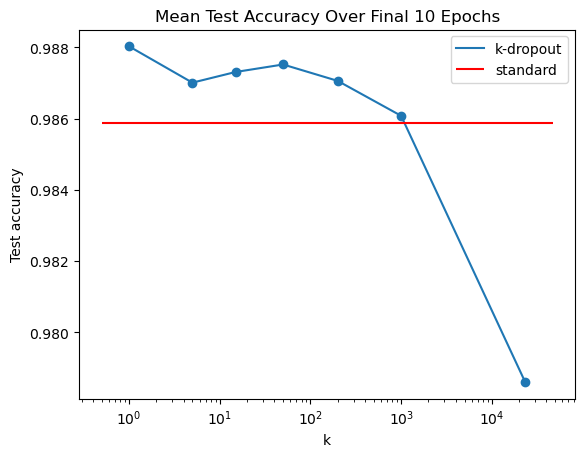

In [10]:
# test accuracy over final few epochs
avg = 10
accuracy = [test_acc_mean[str(k)][-avg:].mean() for k in ks]
plt.scatter(ks, accuracy)
plt.plot(ks, accuracy, label='k-dropout')
plt.hlines(test_acc_mean['standard'][-avg:].mean(), .5, 2*ks[-1], color='r', label='standard')
plt.xscale('log')
plt.legend()
plt.xlabel('k')
plt.ylabel('Test accuracy')
plt.title(f'Mean Test Accuracy Over Final {avg} Epochs')

We observe that the test accuracy for the k-dropout models outperforms no dropout
for most values of $k$ but not in the case where $k$ is equal to the total number of training steps.

In further trials we will sweep across more hyperparameters
and use a larger dataset which may increase the gap in accuracy
between standard and k-dropout. 